In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv("/Users/alexis/Cranfield/AI/assignment/data/train.csv")
val_df = pd.read_csv("/Users/alexis/Cranfield/AI/assignment/data/val.csv")
test_df = pd.read_csv("/Users/alexis/Cranfield/AI/assignment/data/test.csv")

In [3]:
train_df.head()

,image_id,class_name,rad_id,x_min,y_min,x_max,y_max,class_id
0,8138c0bc649a534f449cf703475528ec,Cardiomegaly,R9,835.0,1298.0,1863.0,1662.0,3
1,e8e6ff19c3be05a4ccfb20abc4202d52,Pleural thickening,R10,1768.0,360.0,2130.0,532.0,11
2,de6d6efd88431d3253198106bb070471,No finding,R8,NaN,NaN,NaN,NaN,14
3,01ee6e560f083255a630c41bba779405,Pulmonary fibrosis,R8,1396.0,398.0,1523.0,567.0,13
4,da668869900c862ce12bd06fde5feb8d,Pulmonary fibrosis,R9,1780.0,347.0,2467.0,1246.0,13


In [4]:
val_df.head()

,image_id,class_name,rad_id,x_min,y_min,x_max,y_max,class_id
0,a6bcb9f5d59588d699c5aa83cd3039c7,Nodule/Mass,R10,1801.0,706.0,1890.0,785.0,8
1,4d0664ac3d522bb232afecc65ebb40ca,No finding,R4,NaN,NaN,NaN,NaN,14
2,5806d4429fb183d924976bfd1dfbd4d9,No finding,R15,NaN,NaN,NaN,NaN,14
3,89c2a2ceb6ecf060afecbd7ed85fd24d,No finding,R2,NaN,NaN,NaN,NaN,14
4,00675cd546313f912cadd4ad54415d69,Cardiomegaly,R9,984.0,1486.0,2217.0,1941.0,3


In [5]:
test_df.head()

,image_id,class_name,rad_id,x_min,y_min,x_max,y_max,class_id
0,27b822c5d3b354f096dfb788fd3fa636,Nodule/Mass,R10,277.0,602.0,1177.0,2417.0,8
1,d2ca714f8f06979acfbc0992d65fb211,No finding,R3,NaN,NaN,NaN,NaN,14
2,19367e88f4634c2652d3eed0a2f1f8b2,No finding,R15,NaN,NaN,NaN,NaN,14
3,852ec6a0bcb9608ffee9b3fda0867f91,Aortic enlargement,R8,1669.0,896.0,1972.0,1326.0,0
4,aa9c3097e6d2df7216be1a1642f683c9,No finding,R5,NaN,NaN,NaN,NaN,14


In [6]:
print("Training size:", train_df.shape)
print("Validation size :", val_df.shape)
print("Test size: ", test_df.shape)

Training size: (51953, 8)
Validation size : (5773, 8)
Test size:  (10188, 8)


In [7]:
import numpy as np

print("Training labels:", np.bincount(train_df['class_id']))
print("Validation labels:", np.bincount(val_df['class_id']))
print("Test labels:", np.bincount(test_df['class_id']))

Training labels: [ 5479   213   734  4152   426   765   954  1899  1974  1685  1894  3704
   173  3561 24340]
Validation labels: [ 609   24   82  461   47   85  106  211  219  187  210  412   19  396
 2705]
Test labels: [1074   42  144  814   83  150  187  373  387  331  372  726   34  698
 4773]


### Labels Distribution

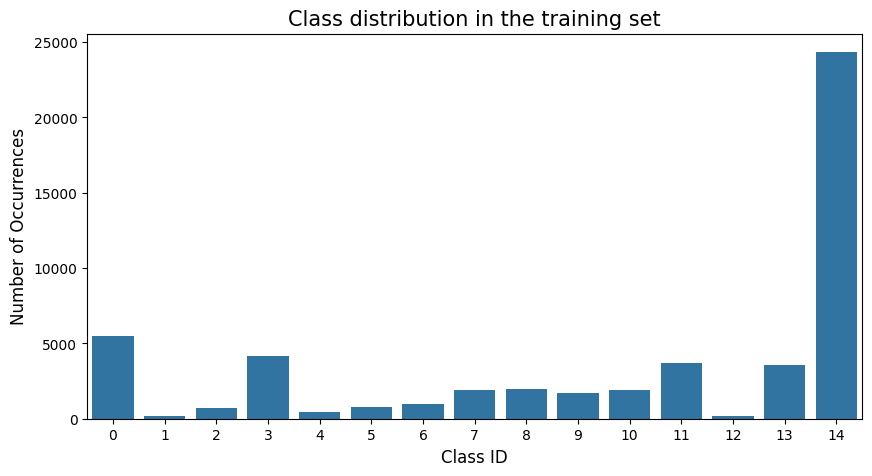

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

classes = train_df['class_id'].unique()
classes.sort()
class_counts = train_df['class_id'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Class distribution in the training set', fontsize=15)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Class ID', fontsize=12)
plt.show()

In [9]:
print("Training set class distribution")
train_df['class_id'].value_counts().sort_index()

Training set class distribution


class_id
0      5479
1       213
2       734
3      4152
4       426
5       765
6       954
7      1899
8      1974
9      1685
10     1894
11     3704
12      173
13     3561
14    24340
Name: count, dtype: int64

### Zero-rule baseline (majority class classifier)

In [10]:
from collections import Counter

train_counter = Counter()
for class_id in train_df['class_id']:
    train_counter.update([class_id])

val_counter = Counter()
for class_id in val_df['class_id']:
    val_counter.update([class_id])

test_counter = Counter()
for class_id in test_df['class_id']:
    test_counter.update([class_id])

print("\nTraining label distribution:")
print(sorted(train_counter.items()))

print("\nValidation label distribution:")
print(sorted(val_counter.items()))

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 5479), (1, 213), (2, 734), (3, 4152), (4, 426), (5, 765), (6, 954), (7, 1899), (8, 1974), (9, 1685), (10, 1894), (11, 3704), (12, 173), (13, 3561), (14, 24340)]

Validation label distribution:
[(0, 609), (1, 24), (2, 82), (3, 461), (4, 47), (5, 85), (6, 106), (7, 211), (8, 219), (9, 187), (10, 210), (11, 412), (12, 19), (13, 396), (14, 2705)]

Test label distribution:
[(0, 1074), (1, 42), (2, 144), (3, 814), (4, 83), (5, 150), (6, 187), (7, 373), (8, 387), (9, 331), (10, 372), (11, 726), (12, 34), (13, 698), (14, 4773)]


In [11]:
majority_class = test_counter.most_common(1)[0]
print("Majority class:", majority_class[0])

baseline_acc = majority_class[1] / sum(test_counter.values())
print("Accuracy when always predicting the majority class:")
print(f"{baseline_acc:.2f} ({baseline_acc*100:.2f}%)")

Majority class: 14
Accuracy when always predicting the majority class:
0.47 (46.85%)


In [12]:
import torch

torch.manual_seed(123)

In [13]:
from ChestXrayDataModule import ChestXrayDataModule

train_df_path = "/Users/alexis/Cranfield/AI/assignment/data/train.csv"
val_df_path = "/Users/alexis/Cranfield/AI/assignment/data/val.csv"
test_df_path = "/Users/alexis/Cranfield/AI/assignment/data/test.csv"
hdf5_path = "/Volumes/ALEXIS/ai_project_cranfield/dicom_images_final.hdf5"

dataModule = ChestXrayDataModule(
    train_dataset_path=train_df_path,
    val_dataset_path=val_df_path,
    test_dataset_path=test_df_path,
    hdf5_path=hdf5_path,
    batch_size=4,
    num_workers=8
)

In [14]:
from ChestXrayLightningModel import ChestXrayLightningModel

model = ChestXrayLightningModel(
    learning_rate=0.005,
    num_classes=15
)

ValueError: Expected argument `iou_thresholds` to either be `None` or a list of floats but got 0.4

In [ ]:
import lightning as L

trainer = L.Trainer(
    max_epochs=10,
    accelerator="gpu",
    devices="auto",
    deterministic=True,
)

In [ ]:
""" model.train()
dataModule.setup("fit")
trainer.fit(model, datamodule=dataModule) """

In [ ]:
dataModule.setup("test")

In [ ]:
import numpy as np


def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append(
            "{0} {1:.4f} {2} {3} {4} {5}".format(
                j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]
            )
        )
    return " ".join(pred_strings)

In [ ]:
model = ChestXrayLightningModel.load_from_checkpoint(
    "/Users/alexis/Cranfield/AI/assignment/Faster-R-CNN/model/version_14/checkpoints/epoch=9-step=9260.ckpt",
    num_classes=15,
)

In [ ]:
detection_threshold = 0.4
results = []
model.model.eval()

In [ ]:
# Ensure the model is on GPU if available
model.to('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from tqdm import tqdm

results = []
with torch.inference_mode():
    for image_ids, images, _ in tqdm(dataModule.test_dataloader(), desc="Evaluating"):
        outputs = model(images)
        for i, output in enumerate(outputs):
            image_id = image_ids[i]
            result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}

            boxes = output["boxes"].data.cpu().numpy()
            labels = output["labels"].data.cpu().numpy() - 1
            scores = output["scores"].data.cpu().numpy()

            # Assuming detection_threshold is defined
            valid = scores >= detection_threshold

            if valid.any():
                result = {
                    "image_id": image_id,
                    "PredictionString": format_prediction_string(
                        labels[valid], boxes[valid], scores[valid]
                    ),
                }
            
            print(result)

            results.append(result)


df = pd.DataFrame(results, columns=["image_id", "PredictionString"])

In [ ]:
""" model = ChestXrayLightningModel.load_from_checkpoint(
    "/Users/alexis/Cranfield/AI/assignment/Faster-R-CNN/model/epoch=9-step=9260.ckpt",
    num_classes=15,
)

dataModule.setup("test")    
train_acc = trainer.test(dataloaders=dataModule.test_dataloader(), model=model) """

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_boxes(image, boxes, labels=None, figsize=(10, 10)):
    """
    Visualize an image with its bounding boxes.

    Parameters:
    - image: a PIL.Image or numpy array of the image.
    - boxes: a list of bounding boxes, each defined by a list of four values [x_min, y_min, x_max, y_max].
    - labels: (Optional) a list of labels for each bounding box.
    - figsize: size of the figure to display.
    """
    # If the image is a torch tensor, convert it to a numpy array
    if torch.is_tensor(image):
        image = image.numpy().transpose((1, 2, 0))
    elif isinstance(image, Image.Image):
        image = np.array(image)

    # Normalize the image array to 0-1 range if it's not already
    if image.max() > 1.0:
        image = image / 255

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.imshow(image)

    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min

        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                 edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        if labels is not None and i < len(labels):
            label = labels[i]
            plt.text(x_min, y_min, str(label), color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

dataModule.setup("fit")

for images, targets in dataModule.train_dataloader():  
    break



In [ ]:
image = images[2]
target = targets[2]

boxes = target['boxes'].numpy()  # Convert tensor to numpy if it's not already
labels = target['labels'].numpy()  # Assuming you want to visualize labels as welltarget

In [ ]:
# Now, visualize the image with bounding boxes
show_image_with_boxes(image, boxes, labels)

In [ ]:
import pandas as pd
pred = pd.read_csv("/Users/alexis/Cranfield/AI/assignment/Faster-R-CNN/example_pred.csv")
pred.head()

In [ ]:
def parse_prediction_string(prediction_string):
    """Parse la chaîne de prédiction pour extraire les bounding boxes et les scores."""
    items = prediction_string.split()
    predictions = []

    for i in range(0, len(items), 6):
        class_id = int(items[i])
        score = float(items[i + 1])
        bbox = [float(coord) for coord in items[i + 2:i + 6]]
        predictions.append({'class_id': class_id, 'score': score, 'bbox': bbox})
    
    return predictions

In [ ]:
def filter_predictions_by_score(predictions, score_threshold=0.5):
    """Filtrer les prédictions pour ne conserver que celles avec un score supérieur au seuil."""
    return [pred for pred in predictions if pred['score'] > score_threshold]


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def show_image_with_predictions(image, predictions):
    """Afficher l'image avec les bounding boxes filtrées selon le score."""
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image, cmap='gray')

    for pred in predictions:
        x_min, y_min, x_max, y_max = pred['bbox']
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(x_min, y_min, f"{pred['class_id']}: {pred['score']:.2f}", color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()


In [ ]:
import logging
import h5py

logging.basicConfig(
    level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s"
)

def get_pixel_array_from_hdf5(hdf5_path, filename):
    """
    Retrieves the pixel array for a given filename from an HDF5 file.

    Parameters:
    - hdf5_path: Path to the HDF5 file.
    - filename: The original file name of the DICOM image.

    Returns:
    - A numpy array of the pixel data if found; None otherwise.
    """
    with h5py.File(hdf5_path, "r") as hdf5_file:
        # Attempt to access the dataset directly by filename.
        # Adjust this part if a more complex naming convention is used.
        unique_filename = None
        for key in hdf5_file.keys():
            if filename in key:
                unique_filename = key
                break
                
        if unique_filename is not None:
            pixel_array = hdf5_file[unique_filename][:]
            return pixel_array
        else:
            logging.error(f"File {filename} not found in HDF5.")
            return None

In [ ]:
import os
import h5py

with h5py.File("/Volumes/ALEXIS/ai_project_cranfield/dicom_images_final.hdf5", "r") as hdf5_file:
    # Count the number of datasets (keys) directly
    num_datasets = len(hdf5_file.keys())

# Print the number of datasets
print(num_datasets)

In [ ]:
filename = "fad39dc356aaa2da58470c6daaba8112"  # This should be the base name of the file you're looking for.
pixel_array = get_pixel_array_from_hdf5("/Volumes/ALEXIS/ai_project_cranfield/dicom_images_final.hdf5", filename+".dicom")
plt.imshow(pixel_array, cmap="gray")

# print the size of the image
original_size = pixel_array.shape[:2]  # (hauteur, largeur)
print(original_size)

In [ ]:
pred = pred[pred['image_id'] == filename]

In [ ]:
pred 

In [ ]:
# Parsez les prédictions
predictions = parse_prediction_string(pred['PredictionString'].values[0])

# Filtrez selon un score de seuil, par exemple 0.9
filtered_predictions = filter_predictions_by_score(predictions, 0.9)

boxes = [pred['bbox'] for pred in filtered_predictions]

In [ ]:
show_image_with_predictions(pixel_array, filtered_predictions)